In [416]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

#from mpltools import special ##leon

# for 3d plot
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-poster')

# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        
        self.time_median = [[] for x in range(5)]
        self.speed_median = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)
        
        self.round_array = []
        self.round_data = [[] for x in range(5)]


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= len(filtered_data)-3) and (filtered_data[i-1].targetid==filtered_data[i+2].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 3*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ['0','30','60','90','120','150','180']

    def _extract_time(self, test, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        #time_flat = [] # not useful, not sorted
        
        ############################
        self.test=test
        print(self.test)
        print("!!")
        
        if (self.test<3):
            lat_order = ['-30','0','30']
        else:
            lat_order = ['0']
            
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            #time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                #time_target = [target.deltatime for target in input_time[lat][lon]]
                #time_lon.append(time_target)
            #time_flat.append(time_lon)

        return time_dict#, time_flat
    
    
    def _cal_round(self, input_time_dict, test):
        r=[[],[],[],[]]
        #print(input_time_dict)
        for lat in input_time_dict:
            for lon in input_time_dict[lat]:
                if ((lon=='0') and (lat=='0')):
                    continue
                for i in range(4):
                    #print("lat", lat, "lon", lon, "i", i, "value", input_time_dict[lat][lon][i])
                    if (i >= len(input_time_dict[lat][lon])):
                        print("Round "+str(i+1)+"("+lat+","+lon+" Not Enough Data")
                        r[i].append(input_time_dict[lat][lon][-1])
                    else:
                        r[i].append(input_time_dict[lat][lon][i])
                    

                
        self.round_array = [np.sum(r[0]), np.sum(r[1]), np.sum(r[2]), np.sum(r[3])]
        
        #print(round_array)
        
        fig,ax=plt.subplots()
        width = 0.6
        plt.bar(range(4), self.round_array, width, label='Round Time', color="G")
        plt.title('Test '+ str(test))
        ax = plt.gca()
        ax.yaxis.grid(True, linestyle = "--")      
        plt.show()
        
        return self.round_array
    
    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(test, input_data): # return
        
        #print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        target_median=[]
        
        #for lon in range(len(input_data)):
    
        if (True):
            
            for lat in range(len(input_data)):
                mean=[]
                std=[]
                median=[]
                #for lat in range(len(input_data[lon])):
                for lon in range(7):
                    #if(lon==1 and lat==0):
                    #if(k2==0):
                    if (input_data[lat][lon] == [0]):
                        mean.append(0)
                        std.append(0)
                        median.append(0)
                        continue
                    data = [target for target in input_data[lat][lon]]
                    
                    mean.append(np.mean(data))
                    std.append(np.std(data))

                    #data.sort();
                    #if (len(data)>2):
                    #    median.append(np.mean(data[1:-1]))
                    #elif (len(data)==2):
                    #    median.append((data[0]+data[1])*0.5)
                    #else:
                    #    median.append(data[0])
                    median.append(np.median(data))


                target_mean.append(mean)
                target_std.append(std)
                target_median.append(median)
                
        if (False):
            mean=[]
            std=[]
            median=[]
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    median.append(0)
                    continue
                data = [target for target in input_data[0][lon]]
                print(input_data)
                print(np.array(data))
                mean.append(np.mean(data))
                std.append(np.std(data))
                median.append(np.median(data))
                
            target_mean=mean[:]
            target_std=std[:]
            target_median=median[:]

            

        return target_mean, target_std, target_median    # 3*7 array[]


    def add_test(self, test, file):
        
        print("test", self.test)
        self.test = test
        print("test", self.test)
        
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict = User._extract_time(self, test, aim_time)
        
        self.round_data[test-1] = User._cal_round(self, time_dict, test)##
        
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = time_flat
        self.speed_array[test-1] = speed_flat
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        self.time_mean[test-1], self.time_std[test-1], self.time_median[test-1] = User._list_stat(test, time_flat)
      
        self.speed_mean[test-1], self.speed_std[test-1], self.speed_median[test-1] = User._list_stat(test, speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def _cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        #print(np.array(ratio).shape)
        #print(np.array(log).shape)
        return ratio,log
    
    def ratio_of(self, data_type, average_type, before, after):
        if (data_type == 'time'):
            if (average_type == 'mean'):
                data_before = self.time_mean[before-1]
                data_after = self.time_mean[after-1]
            if (average_type == 'median'):
                data_before = self.time_median[before-1]
                data_after = self.time_median[after-1]
                
        if (data_type == 'speed'):
            if (average_type == 'mean'):
                data_before = self.speed_mean[before-1]
                data_after = self.speed_mean[after-1]
            if (average_type == 'median'):
                data_before = self.speed_median[before-1]
                data_after = self.speed_median[after-1]
            
        
        #print(np.array(self.speed_mean).shape)
        
        #print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio, log = User._cal_ratio(data_before, data_after)
        return ratio, log
            
        
        
        
        




class Exp(object):
    def __init__(self, _test_order, _user_order, _lat, _lon):
        self._test_order=_test_order
        self.lat=_lat
        self.lon=_lon
        self.user_order = _user_order
        
        self.time_mean_10x3x7 = [] #10*3*7
        self.time_mean_3x7x10 = [] #3*7*10
        self.time_mean_3x7 = [] #3*7
        self.time_std_3x7 = []
        self.time_std_3x7 = []
        self.time_mean_lon = [] #7
        self.time_mean_lat = [] #3
        self.time_mean_overall = 0 #1
        
        self.time_median_10x3x7 = [] #10*3*7
        
        self.speed_mean_10x3x7 = [] #10*3*7
        self.speed_mean_3x7x10 = [] #3*7*10
        self.speed_mean_3x7 = [] #3*7
        self.speed_std_3x7 = []
        self.speed_mean_lon = [] #7
        self.speed_mean_lat = [] #3
        self.speed_mean_overall = 0 #1
        
        self.speed_median_10x3x7 = [] #10*3*7
        
        self.no_user=True
        
        self.round_10x4 = []
        
        
        
        
    def add_user(self, temp_user):
        #print('temp_user.time_array',temp_user.time_array[self._test_order-1])
        #print('self.data_group',np.array(self.data_group))
        self.time_mean_10x3x7.append(temp_user.time_mean[self._test_order-1])
        self.time_median_10x3x7.append(temp_user.time_median[self._test_order-1])
        
        self.speed_mean_10x3x7.append(temp_user.speed_mean[self._test_order-1])
        self.speed_median_10x3x7.append(temp_user.speed_median[self._test_order-1])
        
        self.round_10x4.append(temp_user.round_data[self._test_order-1])
    
    
    def deform(input_data):
        result=[]
        for lat in range(len(input_data[0])):
            r=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                r.append(all_user)
            result.append(r)
        
        return result
    
    
    def _cal_mean_3x7(input_data):
        mean=[]
        std=[]
        for lat in range(len(input_data[0])):
            m=[]
            s=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                m.append(np.mean(all_user)) # *7
                s.append(np.std(all_user))
            mean.append(m)
            std.append(s)# *3
            
        return mean, std
    
    
    def _cal_mean_1(input_data):

        if (input_data[0] != []):
            mean = np.mean(np.delete(np.array(input_data), 7))
            std = np.std(np.delete(np.array(input_data), 7))
        else:
            print(input_data)
            mean = np.mean(np.delete(np.array(input_data), 0))
            std = np.std(np.delete(np.array(input_data), 0))

        return mean
    
    
    def cal_mean_3_old(input_data): # input 3*7
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[1] = np.mean(input_data[1][1:]) # lat=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std(input_data[1][1:]) # lat=0
        
        return mean, std
    
    def cal_mean_3(input_data): # input 10*3*7
        mean=[]
        std=[]
        for lat in range(3):
            data=[]
            
            for user in range(len(input_data)):  
                for lon in range(7):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
    
    
    def cal_mean_7_old(input_data_raw): # input 3*7
        input_data = np.array(input_data_raw).T
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[0] = np.mean([input_data[0][0],input_data[0][2]]) # lon=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std([input_data[0][0],input_data[0][2]])# lat=0
        
        return mean, std
    
    def cal_mean_7(input_data): # input 10*3*7
        mean=[]
        std=[]
        #for lat in range(3):
        for lon in range(7):
            data=[]
            
            for user in range(len(input_data)):  
                #for lon in range(7):
                for lat in range(3):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
        
    
    def cal_mean(self):
        self.time_mean_3x7, self.time_std_3x7 = Exp._cal_mean_3x7(self.time_mean_10x3x7)

        self.time_mean_overall = Exp._cal_mean_1(self.time_mean_10x3x7)
        
        self.speed_mean_3x7, self.speed_std_3x7 = Exp._cal_mean_3x7(self.speed_median_10x3x7) #####median/mean
        self.speed_mean_overall = Exp._cal_mean_1(self.speed_median_10x3x7)

        #self.time_mean_overall = np.mean(np.delete(np.array(self.time_mean_3x7), 7))
        #std
        #self.speed_mean_overall = np.mean(np.delete(np.array(self.speed_mean_3x7), 7))
        
        #self.time_mean_lat = [np.mean(self.time_mean_3x7[i]) for i in range(len(self.time_mean_3x7))]
        #self.time_mean_lat[1] = np.mean(self.time_mean_3x7[1][1:]) # lat=0
        #temp = np.transpose(self.time_mean_3x7)
        #self.time_mean_lon = [np.mean(temp[i]) for i in range(len(temp))]
        #self.time_mean_lon[0] = np.mean([temp[0][0],temp[0][2]]) # lon=0


In [417]:
def plot_single_user(which_type, input_data):
    
    data = input_data
    lon_key = [a for a in User.LON_KEY]
    lon_key.pop(0)
    
    if (len(input_data)>2):
        data_short = [a for a in data[1]]
        data_short.pop(0)
        plt.plot()

        plt.plot(User.LON_KEY, data[0], '-v', label="-30")
        plt.plot(lon_key, data_short, '-o', label="0")
        plt.plot(User.LON_KEY, data[2], '-^', label="30")
        
    else:
        data_short = [a for a in data[0]]
        data_short.pop(0)
        plt.plot()


        plt.plot(lon_key, data_short, '-o', label="0")

    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    if (which_type=='ratio'):
        plt.ylim(0,2)
        ax.set_title('Ratio')
        plt.ylabel('Ratio Value')
    if (which_type=='log'):
        plt.ylim(-1,1)
        ax.set_title('Log')
        plt.ylabel('Log Value')
    
    plt.legend(title="Latitude")
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()
    
    
def plot_3d(data):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    #X = range(3)
    #Y = range(6)
    #Z = data.speed_mean[0][X][Y]
    
    # as plot_surface needs 2D arrays as input
    #x = np.arange(10)
    y = [-30,0,30]
    #y = np.array(range(10,15))
    x = [0,30,60,90,120,150,180]
    # we make a meshgrid from the x,y data
    X, Y = np.meshgrid(x, y)
    #Z = np.sin(np.sqrt(X**2 + Y**2))
    Z = np.array(data.speed_mean[0])
    #X = np.arange(-5, 5, 0.25)
    #Y = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    #surf = ax.plot_surface(X, Y, Z, alpha=1)
    #ax.plot_wireframe(X, Y, Z, alpha=1)
    
    #cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=30, cmap=cm.coolwarm)
    
    print(np.array(data.speed_mean[0]).shape)
    print(X)
    print(Y)
    print(Z.flatten())
    
    width = depth = 10
    bottom = np.zeros(21)
    print(bottom)
    ax.bar3d(X.flatten(), Y.flatten(), bottom, width, depth, Z.flatten(), shade=True)
    #ax.set_title('Shaded')
    
    plt.xticks(x,x)
    plt.yticks(y,y)

    
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
    for ix in range(3):
        for iy in range(7):
            ax.scatter(float(User.LON_KEY[iy]), float(User.LAT_KEY[ix]), data.speed_mean[0][ix][iy], c='r', marker='o')

    plt.show()


def plot_img(data):
    y = [-30,0,30]
    x = [0,30,60,90,120,150,180]

    fig, ax = plt.subplots()
    Z = np.array(data)
    im = ax.imshow(Z, cmap=cm.gray)
    #interpolation='bicubic'
    
    plt.xticks(range(len(x)),x)
    plt.yticks(range(len(y)),y)
    
    plt.show()

def plot_bar(mean_1,  mean_2, std_1=None, std_2=None):
    
    if (np.array(mean_1).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    
    elif (np.array(mean_1).shape == (7,3)):
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[-30, 0, 30]
        
    elif (np.array(mean_1).shape == (3,)):
        key1=[-30, 0, 30]
        key2=[]
        
    elif (np.array(mean_1).shape == (7,)):      
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[]
    
    elif (np.array(mean_1).shape == ()):
        key1=[]
        key2=[]
    
    elif (np.array(mean_1).shape == (1,7)):
        key1=[0]
        key2=[0, 30, 60, 90, 120, 150, 180]
        
    else:
        print("Error???")
        key1=[]
        key2=[]
        
    #if ( (std_1==None) or (std_2==None) ):
     #   std_1=np.zeros_like[mean_1]
      #  std_2=np.zeros_like[mean_2]
    
        
    plt.figure(1, figsize = (12,16))
    
    #fig, ax = plt.subplots()
    
    plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    if (len(key1)>2):
        width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    else:
        width = 2
    
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(0,0, label="test1", color="C0")
    plt.bar(0,0, label="test2", color="C3")
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    plt.subplot(2, 1, 2)
    
    #if (np.array(mean_1).shape == (3,7)):
    if (False):
        
        #for k1 in range(len(key1)):
        #    for k2 in range(len(key2)):


        lon_key = [a for a in User.LON_KEY]
        lon_key.pop(0)

        data_1_short = [a for a in mean_1[1]]
        data_1_short.pop(0)

        data_2_short = [a for a in mean_2[1]]
        data_2_short.pop(0)

        plt.plot(User.LON_KEY, mean_1[0], ':v', color = 'C1', label="-30")
        plt.plot(lon_key, data_1_short, ':o', color = 'C2', label="0")
        plt.plot(User.LON_KEY, mean_1[2], ':^', color = 'C3', label="30")

        plt.plot(User.LON_KEY, mean_2[0], '-v', color = 'C1', label="-30")
        plt.plot(lon_key, data_2_short, '-o', color = 'C2', label="0")
        plt.plot(User.LON_KEY, mean_2[2], '-^', color = 'C3', label="30")

    #if (np.array(mean_1).shape == (7,3)):
    if (True):
        for k1 in range(len(key1)):
            if (0 in mean_1[k1]):
                data_1= list(mean_1[k1])[:]
                data_2= list(mean_2[k1])[:]
                data_1.remove(0.)
                data_2.remove(0.)
                kkey = key2[:]
                kkey.remove(0)
                
                plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), label=str(key1[k1]))
                plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            else:
                plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1), label=str(key1[k1]))
                plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            
        
        
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude")
    ax.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    
    plt.show()

    

def plot_bar_single(mean):
    
    
    key2=[0, 30, 60, 90, 120, 150, 180]
    
    if (len(mean)>2):
        key1=[-30, 0, 30]
        width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    else:
        key1=[0]
        width = 2
        
    

    
    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean[k1][k2], 2*width, #label=str(key2[k2]
                    color="G", alpha=1-opacity*k2)
            
            x_axis.append(x)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))

    yref1=0.01
    yref2=0.05
    yref3=0.1
    
    plt.axhline(y=yref1,linewidth=1, color='r')
    plt.axhline(y=yref2,linewidth=1, color='r')
    plt.axhline(y=yref3,linewidth=1, color='r')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.legend(title="Longitude")
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    
    plt.xticks(x_axis, x_label, rotation=90)

3
!
test 1
test 3
Reading ../Users/14/3.txt
3
!!


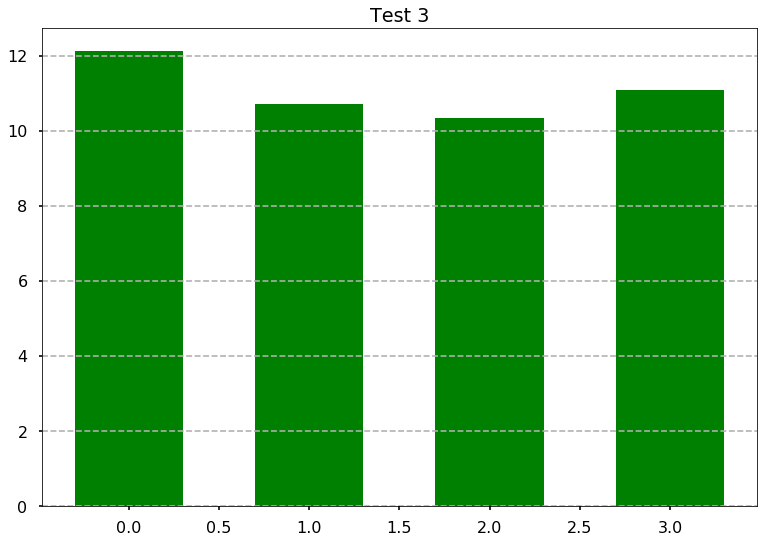

4
!
test 3
test 4
Reading ../Users/14/4.txt
4
!!


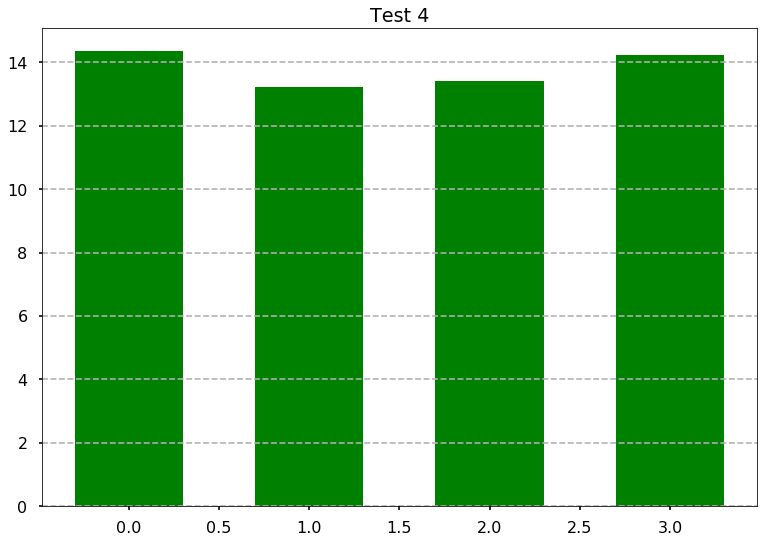

5
!
test 4
test 5
Reading ../Users/14/5.txt
5
!!


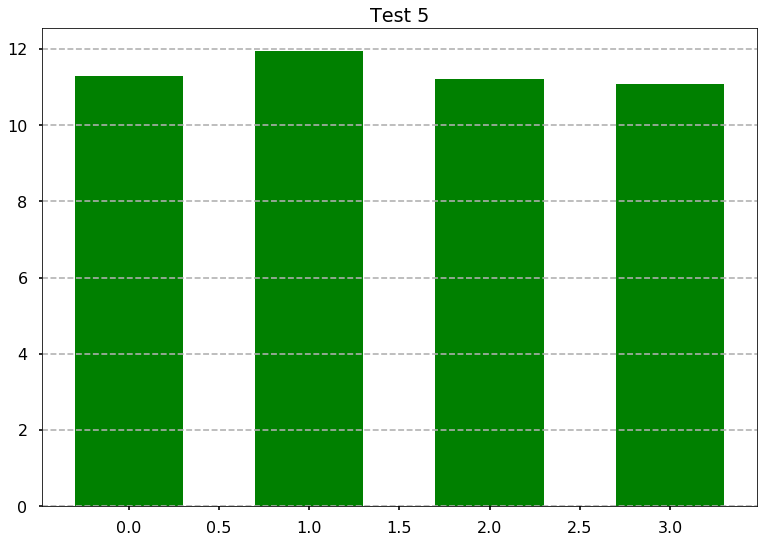

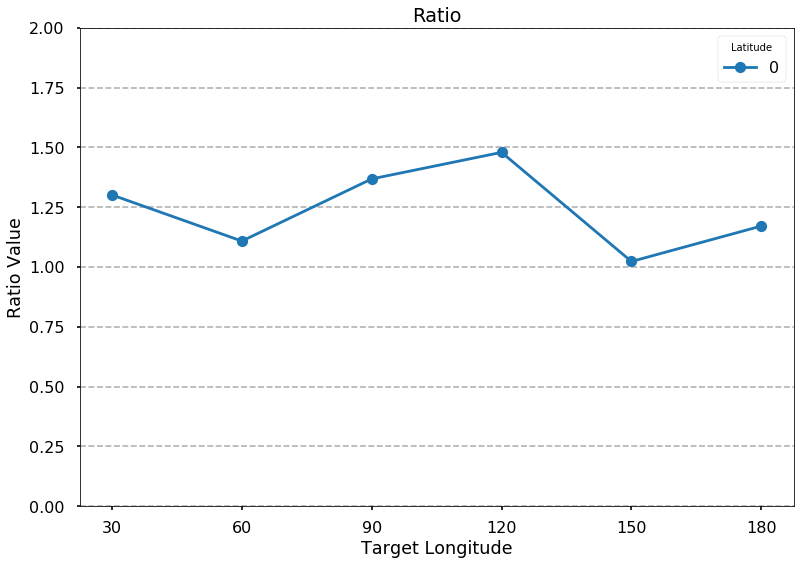

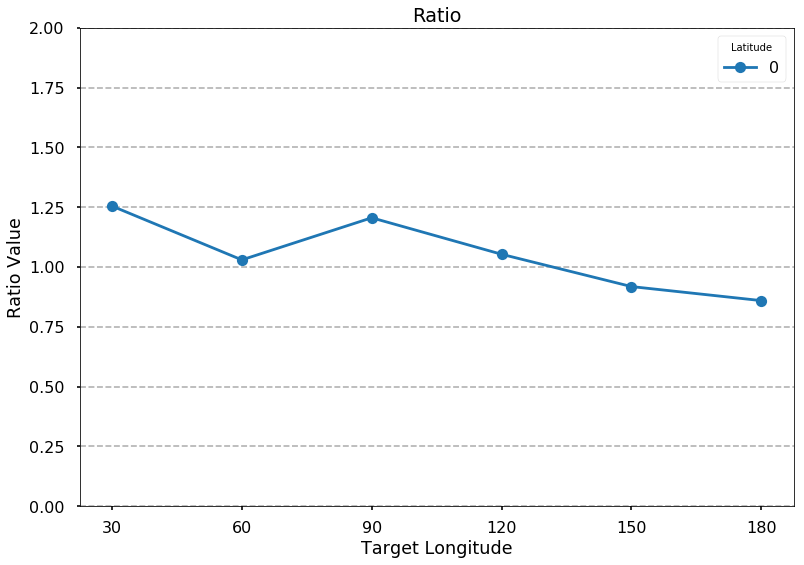

3
!
test 1
test 3
Reading ../Users/16/3.txt
3
!!


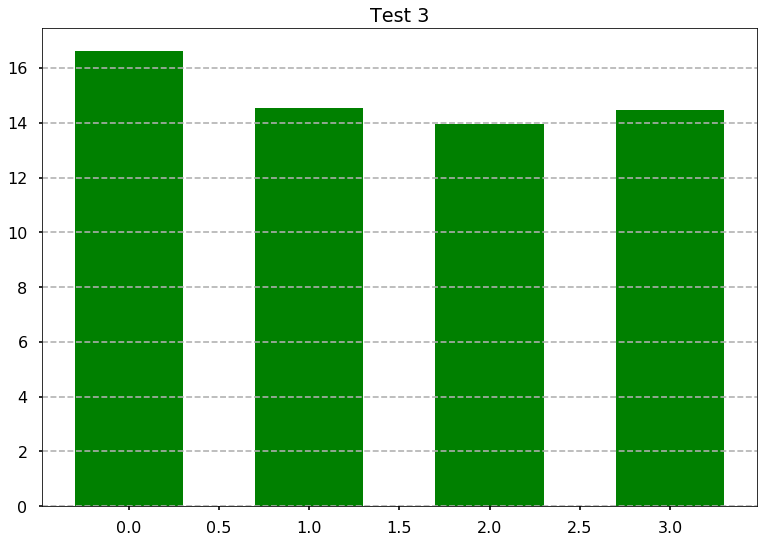

4
!
test 3
test 4
Reading ../Users/16/4.txt
4
!!


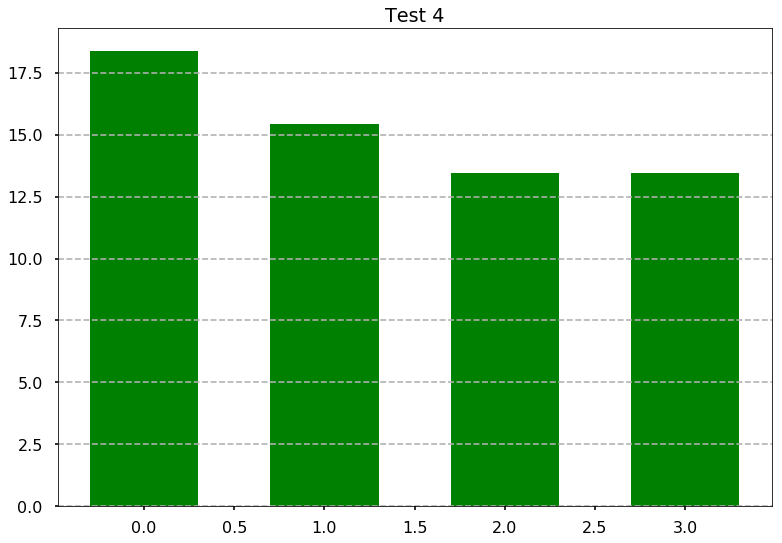

5
!
test 4
test 5
Reading ../Users/16/5.txt
5
!!


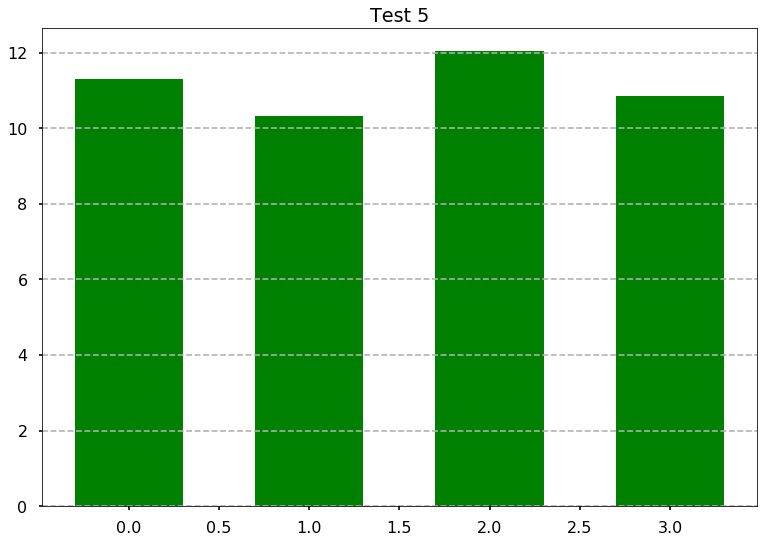

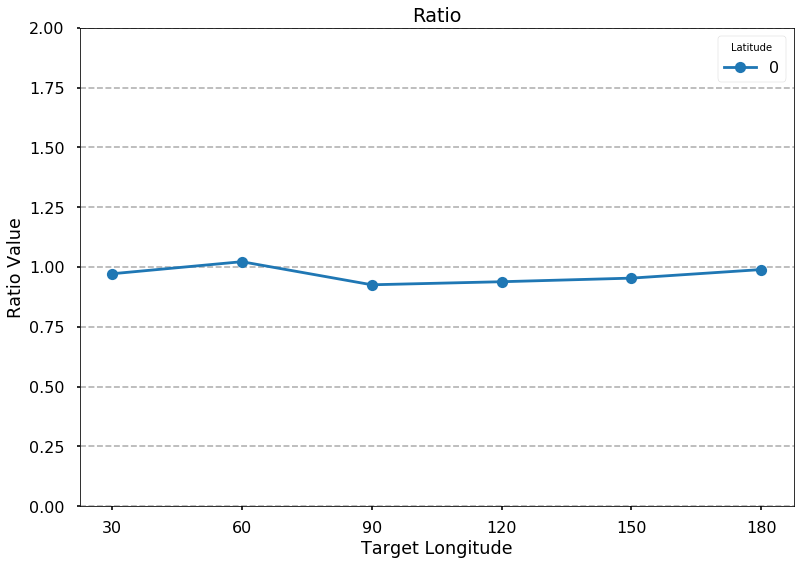

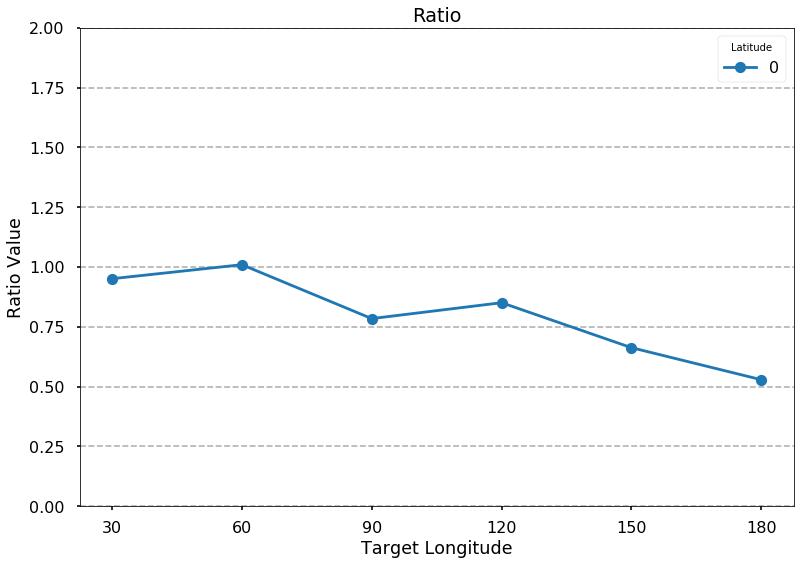

3
!
test 1
test 3
Reading ../Users/17/3.txt
3
!!


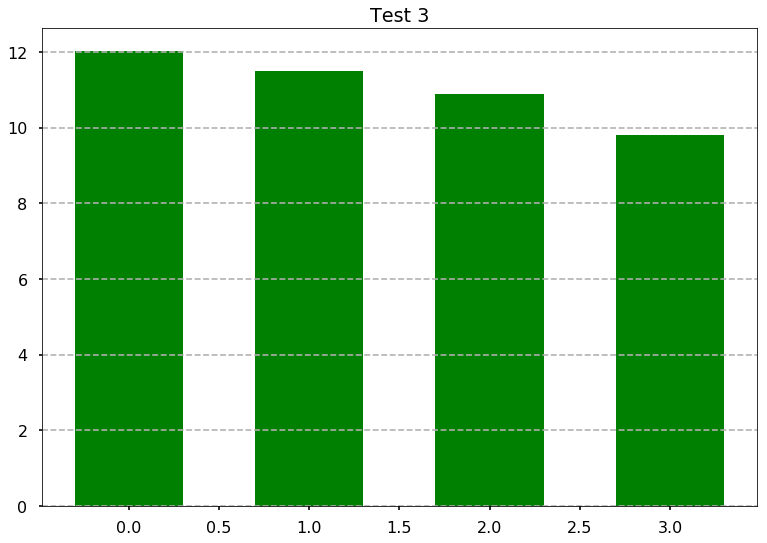

4
!
test 3
test 4
Reading ../Users/17/4.txt
4
!!


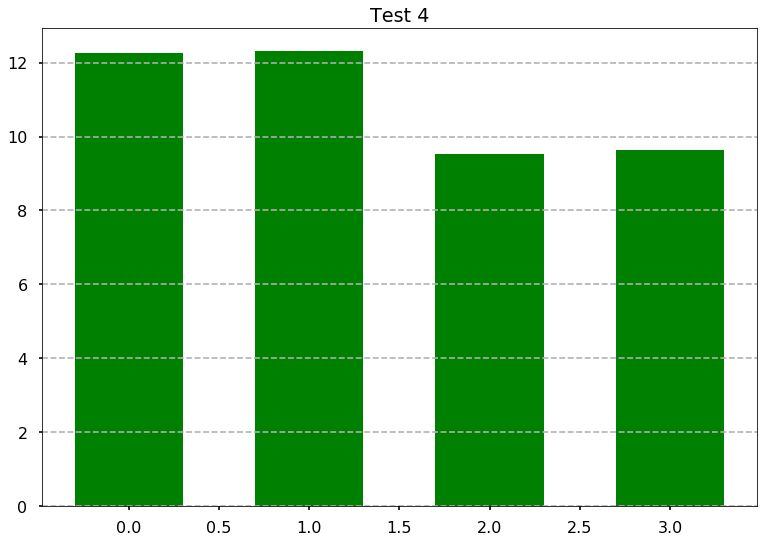

5
!
test 4
test 5
Reading ../Users/17/5.txt
5
!!


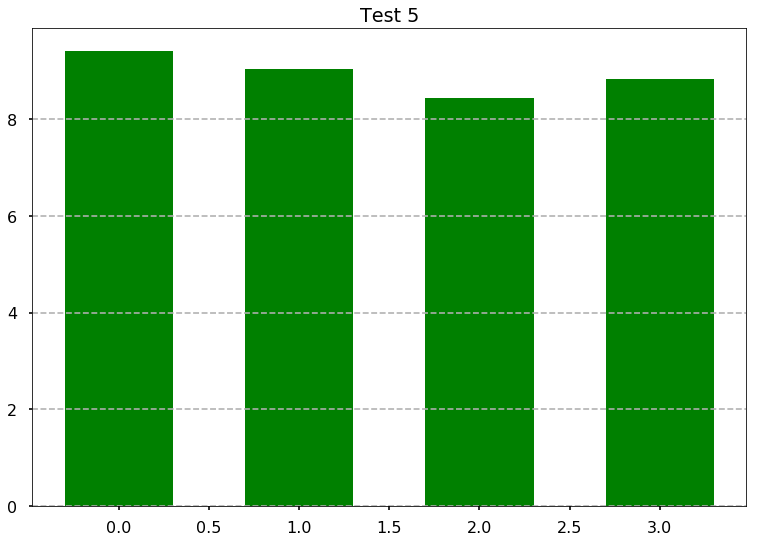

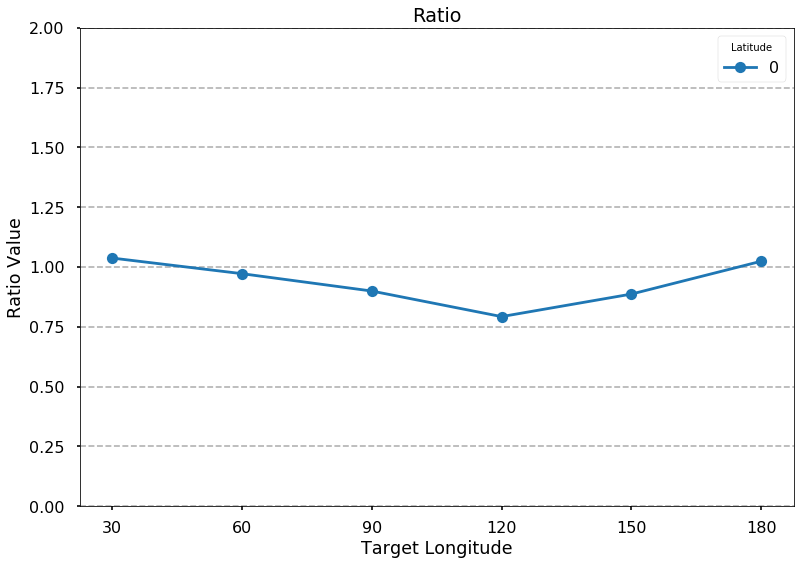

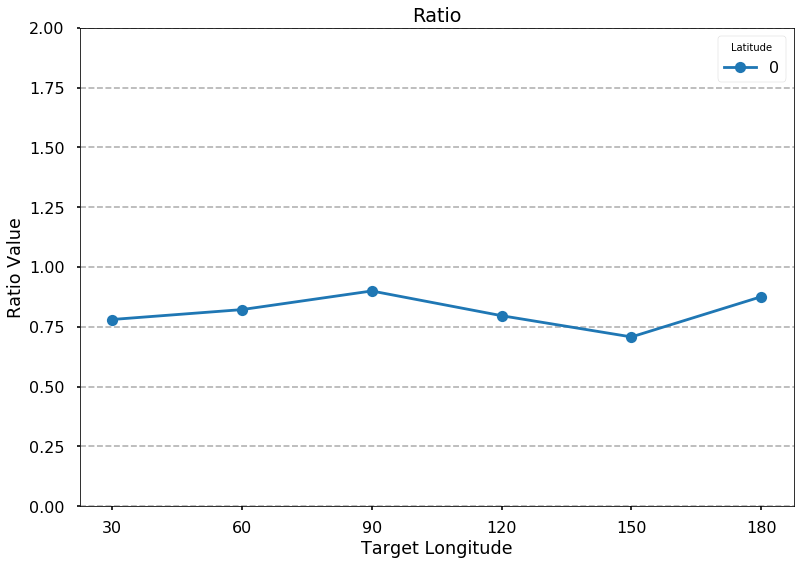

3
!
test 1
test 3
Reading ../Users/18/3.txt
3
!!


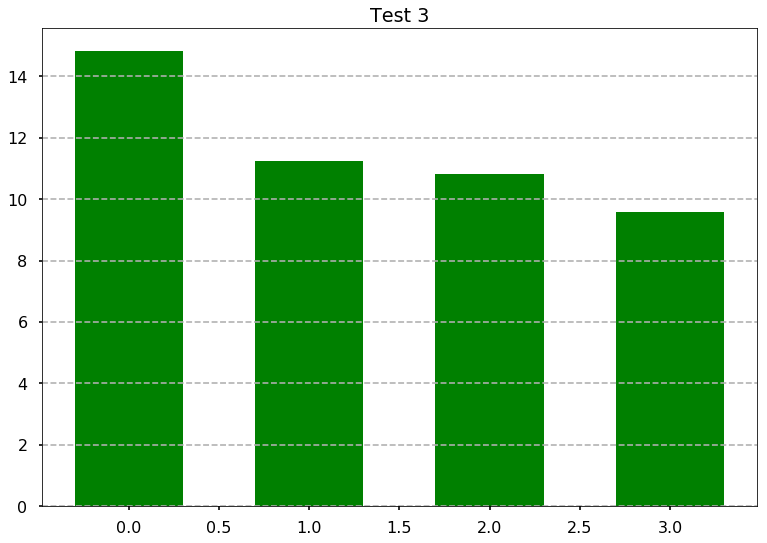

4
!
test 3
test 4
Reading ../Users/18/4.txt
4
!!


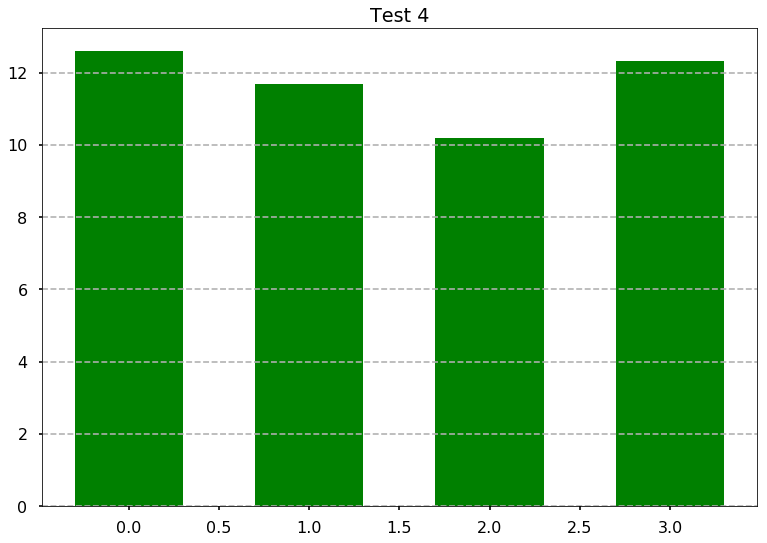

5
!
test 4
test 5
Reading ../Users/18/5.txt
5
!!


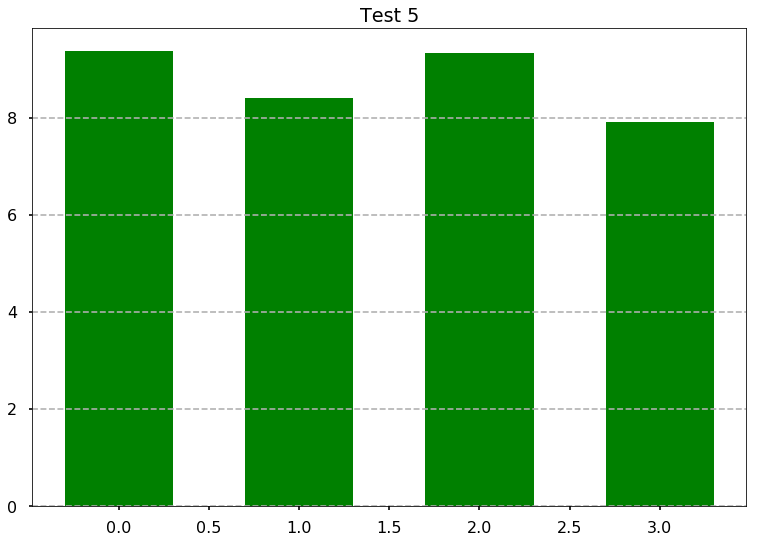

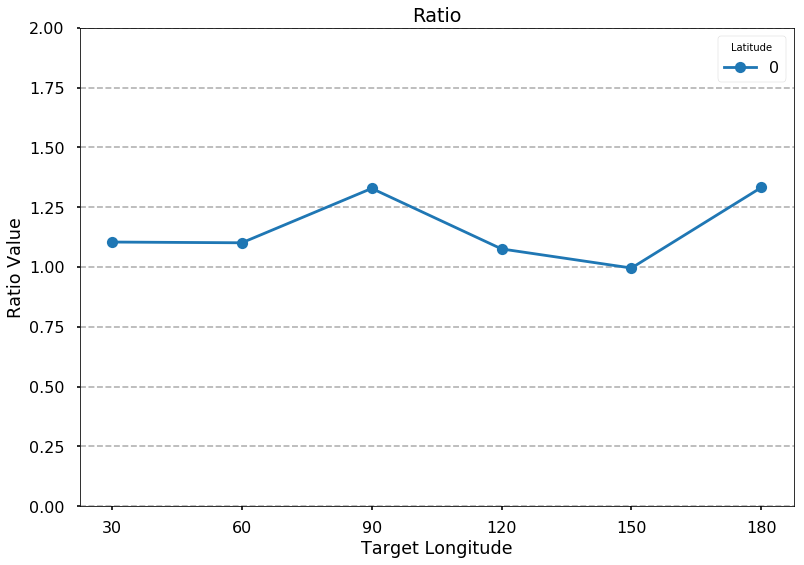

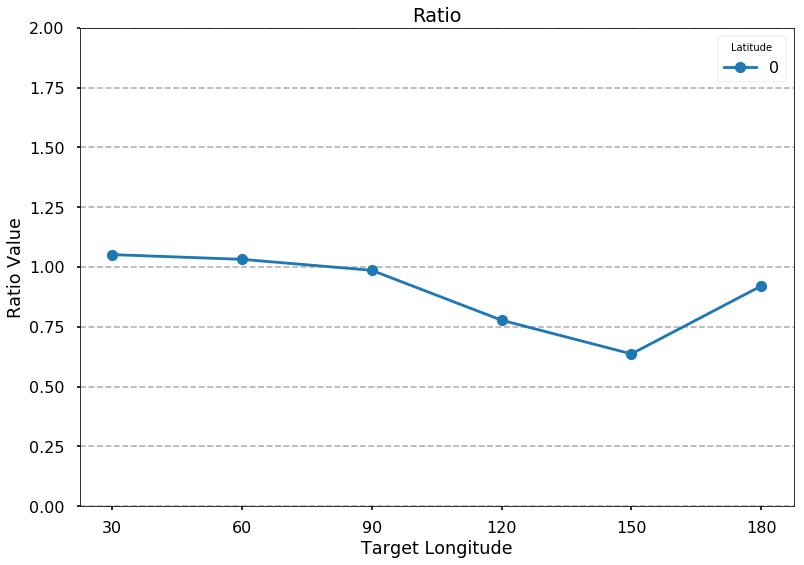

3
!
test 1
test 3
Reading ../Users/19/3.txt
3
!!


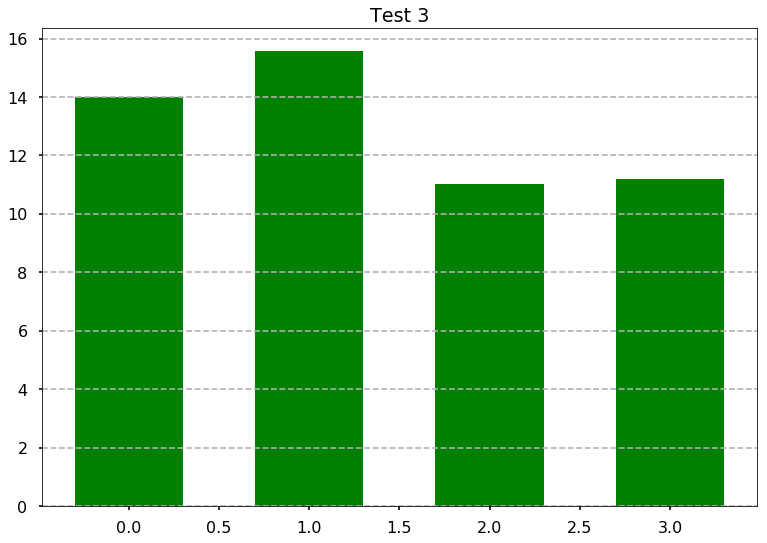

4
!
test 3
test 4
Reading ../Users/19/4.txt
4
!!


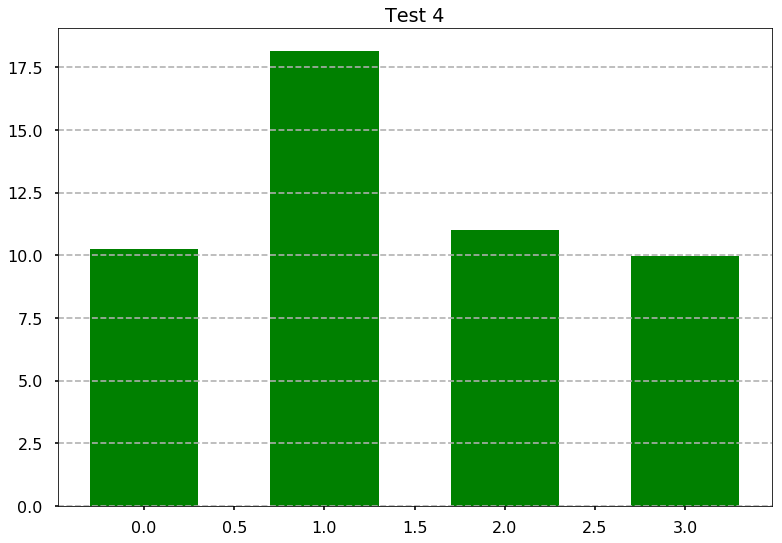

5
!
test 4
test 5
Reading ../Users/19/5.txt
5
!!


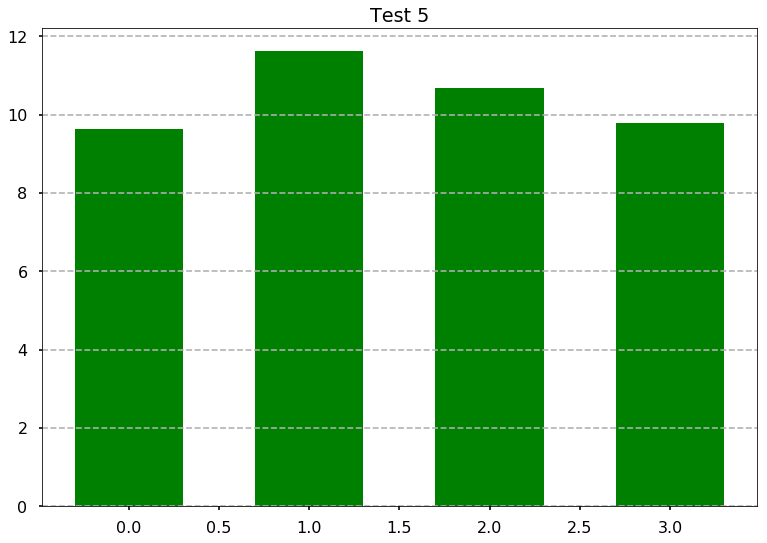

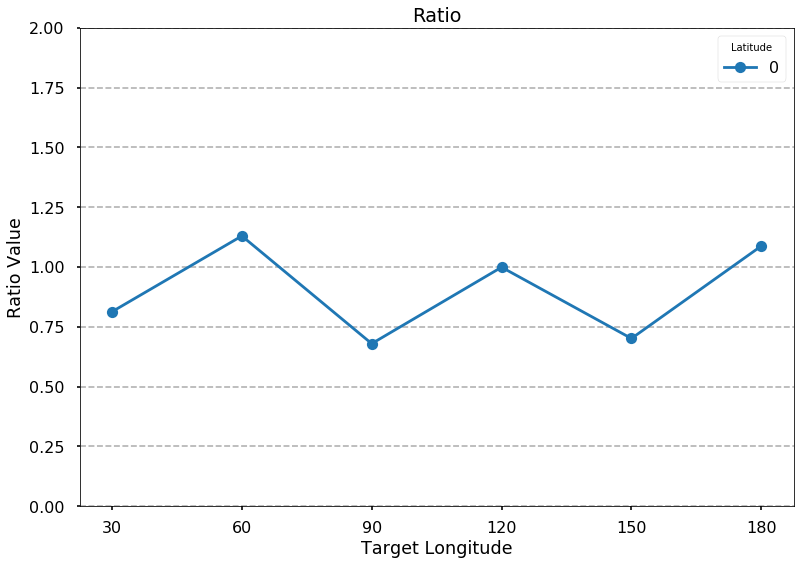

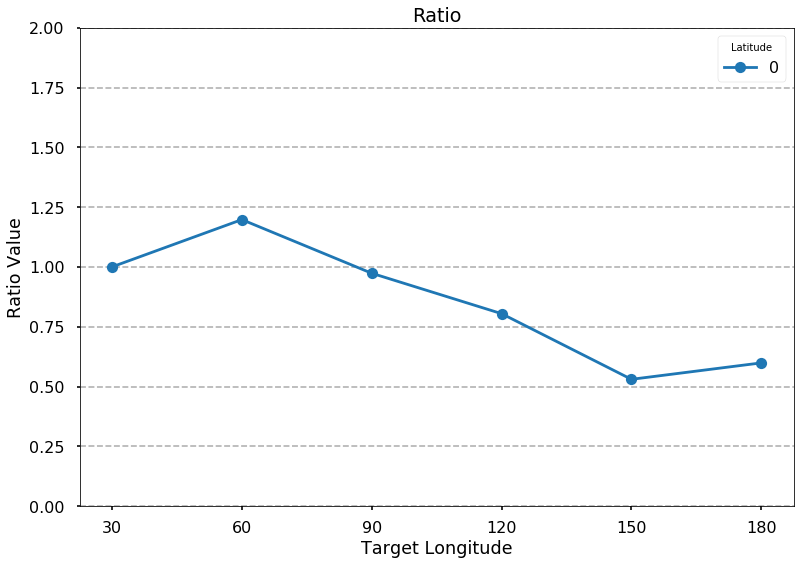

3
!
test 1
test 3
Reading ../Users/15/3.txt
3
!!
Round 4(0,60 Not Enough Data


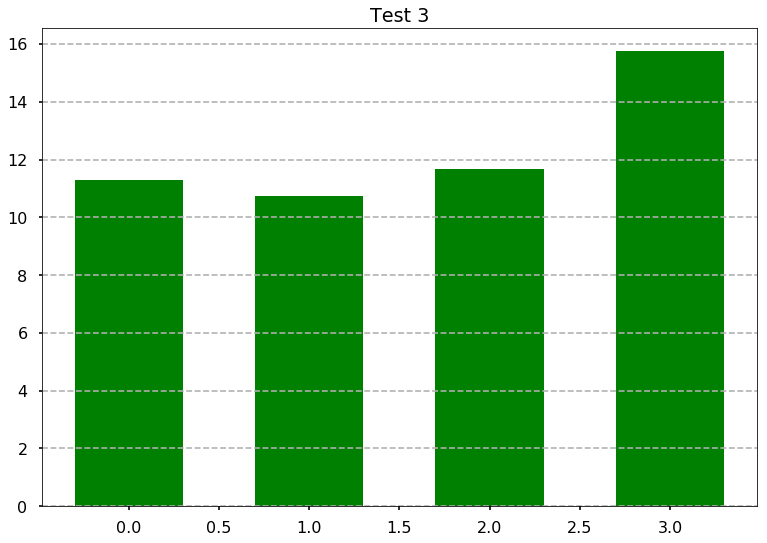

4
!
test 3
test 4
Reading ../Users/15/4.txt
4
!!


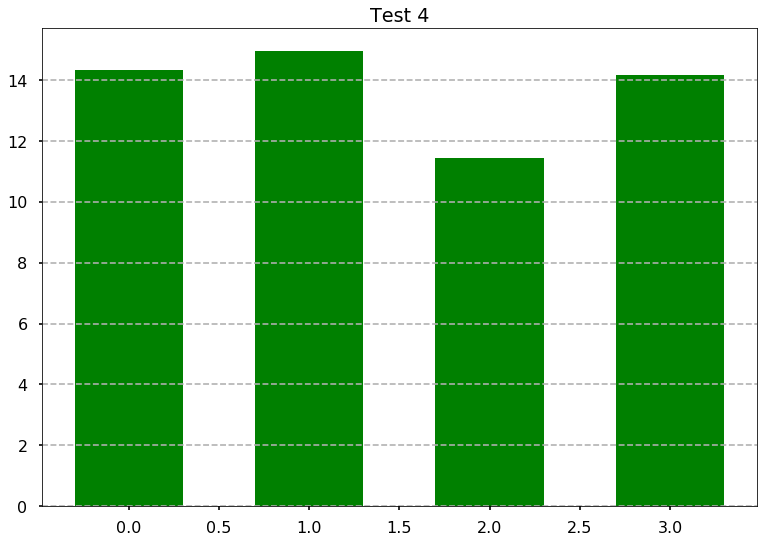

5
!
test 4
test 5
Reading ../Users/15/5.txt
5
!!


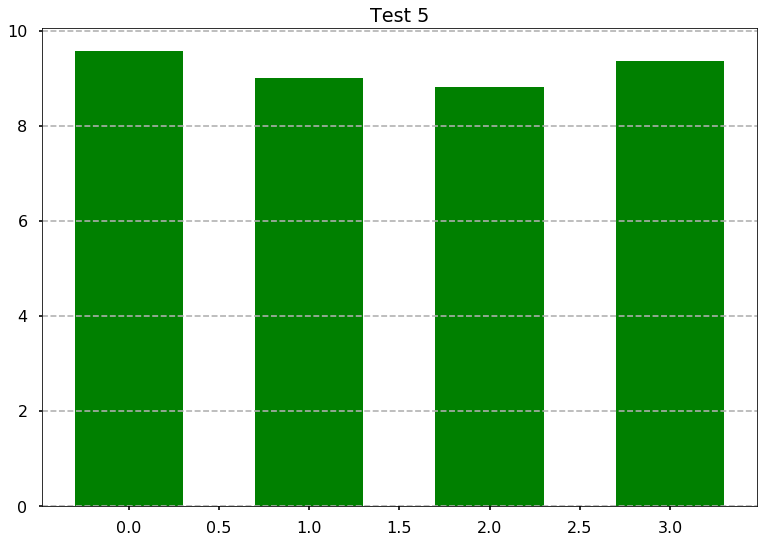

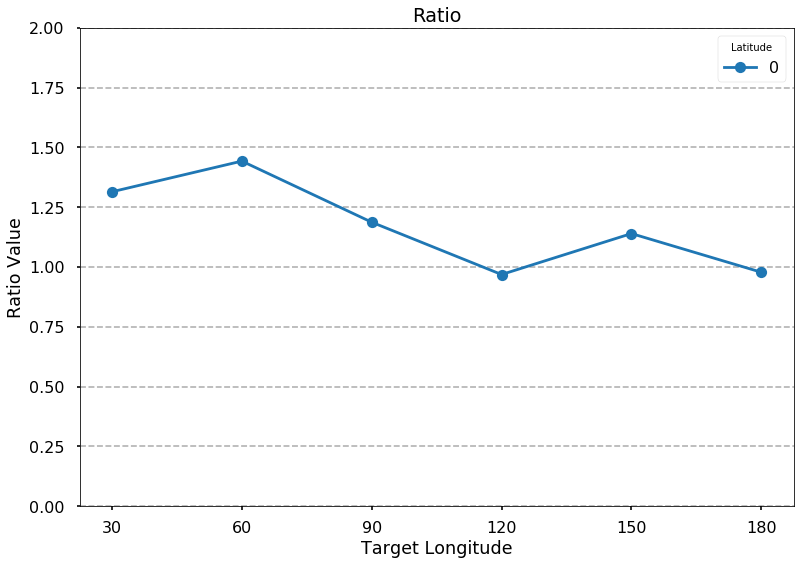

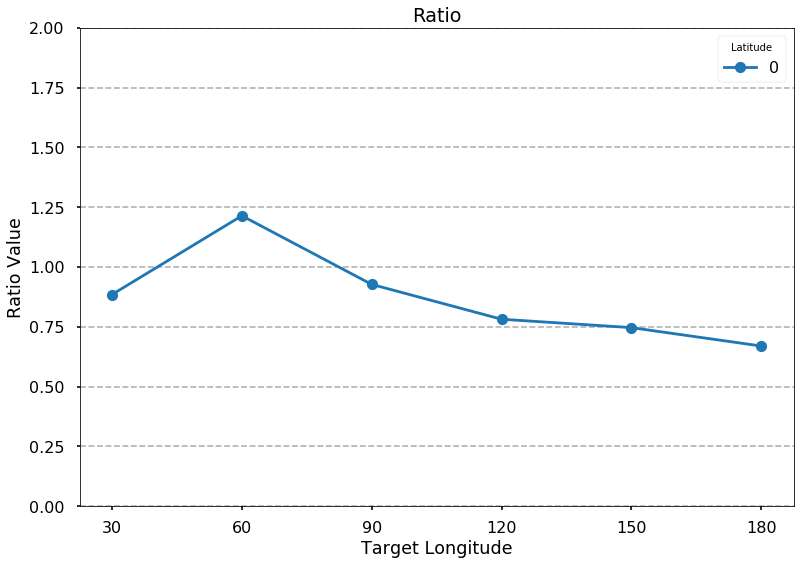

[list([1, 2]) list([1, 2, 3])]


In [418]:
###################### choose user
#users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[1,2,3,4,5,9,10,14,6,12]
#users=[1,2,3,4,5,6,8,9,10,12] #roshan
users=[14,16,17,18,19,15]
#users=[1,2]
######################


user_all = [] 
test1 = Exp(1,1,1,1)
test2 = Exp(2,1,1,1)
test3 = Exp(3,1,1,1)
test4 = Exp(4,1,1,1)
test5 = Exp(5,1,1,1)




for uid in range(len(users)):
    baseFolder=str(users[uid])
   
    #test_id=[1,2]
    test_id=[3,4,5]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user_temp.time_raw[0])
    #print('!')
    for idx in range(len(test_id)):
        print(test_id[idx])
        print('!')
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
        
    
    test1.add_user(user_temp)
    test2.add_user(user_temp)
    
    test3.add_user(user_temp)
    test4.add_user(user_temp)
    test5.add_user(user_temp)
    
    user_all.append(user_temp)
    #print(np.array(Test1.data_group).shape)
    #print('!')

    
    #User.dict_print(user_all[0].time_raw[0])
    #User.dict_print(user_all[1].time_raw[1])
    
    if (False):
        #print(np.array(user_all[1].time_mean[0]).shape)
        ratio, log = user_temp.ratio_of('time', 'mean',1,2)
        ratio_med, log_med = user_temp.ratio_of('time', 'median',1,2)
        #print(np.array(ratio).shape)

        ####plot_single_user('ratio', ratio)
        ####plot_single_user('ratio', ratio_med)
        print(np.array(ratio).shape)
        #plot_single_user(log)
        
    if (True):
        ratio_34, log_34 = user_temp.ratio_of('time', 'mean',3,4)
        ratio_34_med, log_34_med = user_temp.ratio_of('time', 'median',3,4)
        ratio_35, log_35 = user_temp.ratio_of('time', 'mean',3,5)
        ratio_35_med, log_35_med = user_temp.ratio_of('time', 'median',3,5)
        
        plot_single_user('ratio', ratio_34_med)
        plot_single_user('ratio', ratio_35_med)
        
    
    


array1 = np.array([[1,2],[1,2,3]])
print(array1)




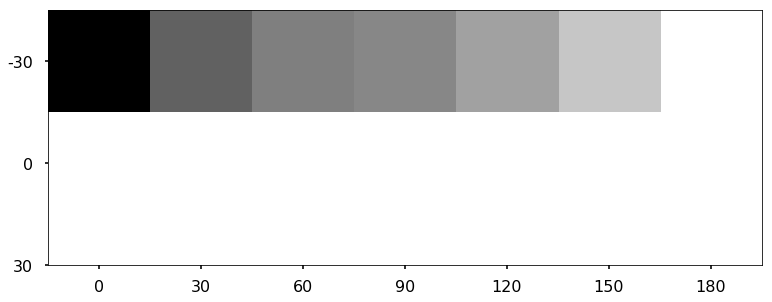

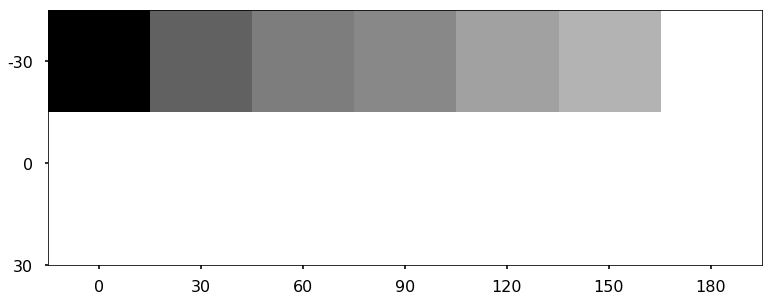

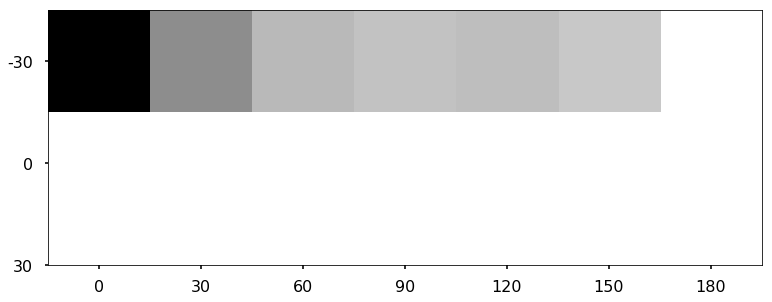

In [419]:
##########
if (True):
    Exp.cal_mean(test3)
    Exp.cal_mean(test4)
    Exp.cal_mean(test5)
    
    plot_img(np.array(test3.time_mean_3x7))
    plot_img(np.array(test4.time_mean_3x7))
    plot_img(np.array(test5.time_mean_3x7))
    


if (False):
    #Exp.cal_mean(test1)
    #Exp.cal_mean(test2)

    #print(np.array(test1.time_mean_group))
    print(np.array(test1.time_mean_3x7))
    print(np.delete(np.array(test1.time_mean_3x7), 7))
    print(test1.time_mean_overall, test2.time_mean_overall)

    plot_img(np.array(test1.time_mean_3x7))
    plot_img(np.array(test2.time_mean_3x7))

[]
[]
[]
[]
(1, 7)
[[0.         1.30332806 1.65561713 1.80081794 2.13314415 2.38142892
  3.37090656]]
[[0.         1.21777056 1.59791944 1.67765389 1.64553556 1.73059944
  2.20767667]]


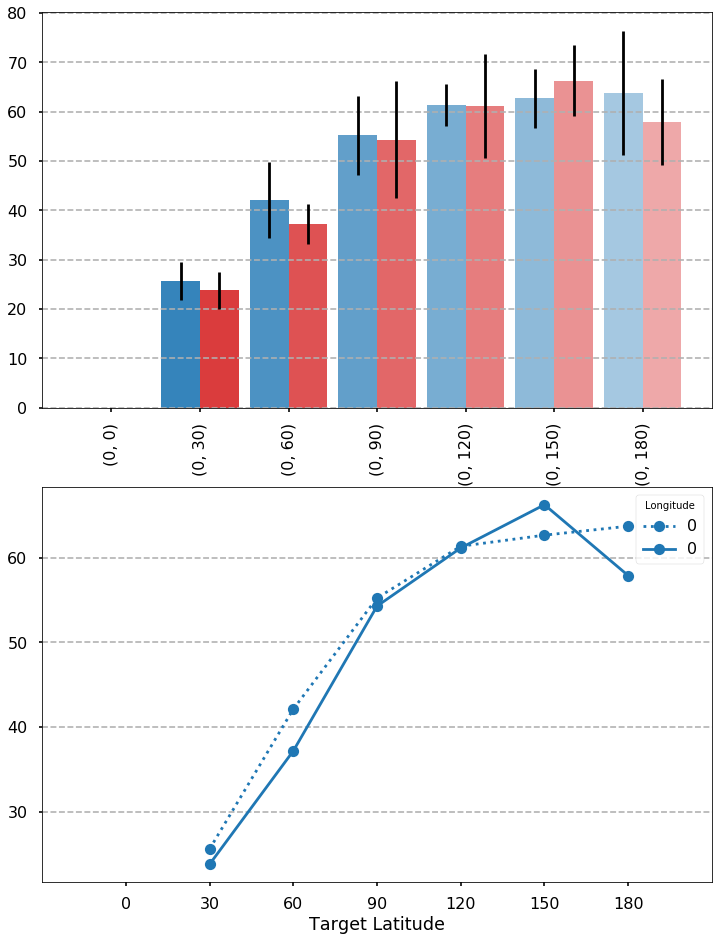

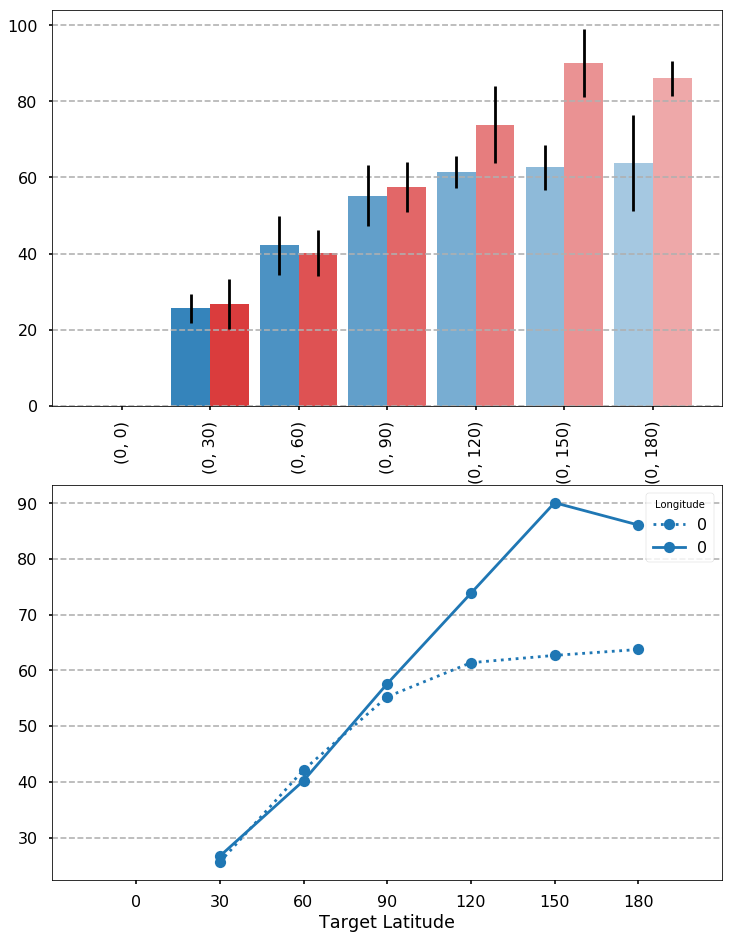

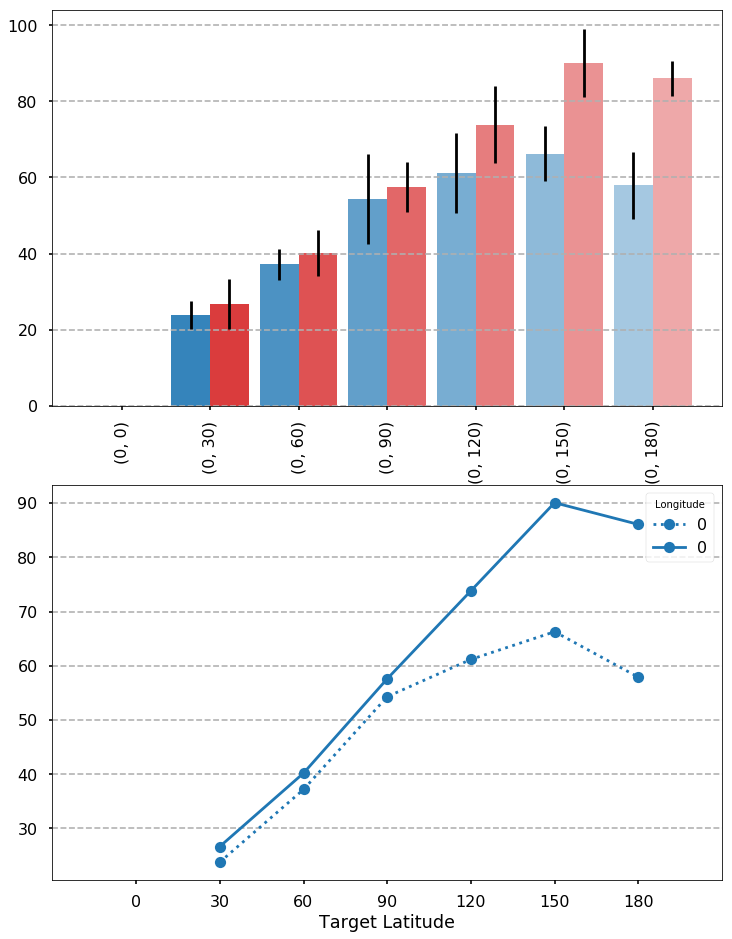

In [420]:
print(test1.time_mean_lat)
print(test2.time_mean_lat)
print(test1.time_mean_lon)
print(test2.time_mean_lon)

#print(Exp.cal_mean_3_old(test1.time_mean_3x7))
#print(Exp.cal_mean_3(test1.time_mean_10x3x7))
#print(Exp.cal_mean_3(test2.time_mean_10x3x7))

#print(Exp.cal_mean_7_old(test1.time_mean_3x7))
#print(Exp.cal_mean_7(test1.time_mean_10x3x7))
#print(Exp.cal_mean_7(test2.time_mean_10x3x7))

if (False):
    print(np.array(test1.time_mean_3x7))
    print(np.array(test2.time_mean_3x7))

    plot_bar(test1.speed_mean_3x7, test2.speed_mean_3x7, test1.speed_std_3x7, test2.speed_std_3x7)

    plot_bar(np.array(test1.speed_mean_3x7).T, np.array(test2.speed_mean_3x7).T,
             np.array(test1.speed_std_3x7).T, np.array(test2.speed_std_3x7).T)

if (True):
    print(np.array(test3.time_mean_3x7).shape)
    print(np.array(test4.time_mean_3x7))
    print(np.array(test5.time_mean_3x7))
    
    plot_bar(test3.speed_mean_3x7, test4.speed_mean_3x7, test3.speed_std_3x7, test4.speed_std_3x7)
    plot_bar(test3.speed_mean_3x7, test5.speed_mean_3x7, test3.speed_std_3x7, test5.speed_std_3x7)
    plot_bar(test4.speed_mean_3x7, test5.speed_mean_3x7, test4.speed_std_3x7, test5.speed_std_3x7)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(6, 1, 7)
(6, 1, 7)
(6, 1, 7)
(6, 1, 7)
(6, 1, 7)
(6, 1, 7)
[[[ 0.         25.37389498 37.75026953 57.46463825 65.84092233
   68.37879351 67.0937592 ]]

 [[ 0.         19.2931177  31.70310413 42.59960771 53.0793261
   53.72410114 44.53432895]]

 [[ 0.         27.33832121 42.67325028 56.94763438 61.68379181
   67.18086146 73.63400589]]

 [[ 0.         26.55851839 41.08045854 64.99308004 62.1864199
   66.71675602 79.86723826]]

 [[ 0.         24.36519892 43.28760275 54.4357112  65.55603189
   57.28757705 59.93492631]]

 [[ 0.         30.30382872 48.20165818 55.85589708 59.54732298
   65.44821321 50.44520958]]]
[[[0, 20.35583328469539, 31.658429696230733, 42.32145178645769, 43.72531073663174, 68.72881233614712, 60.926947498923745]], [[0, 21.76667685393015, 33.61684456318029, 45.28139024812818, 57.19601174744582, 55.80835492938179, 45.68077120854981]], [[0, 27.490812609531975, 39.68596881664659, 59.09694757530471, 73.6421498911271, 70.72927797990562, 70.68887392585282]], [[0, 26.4066332719

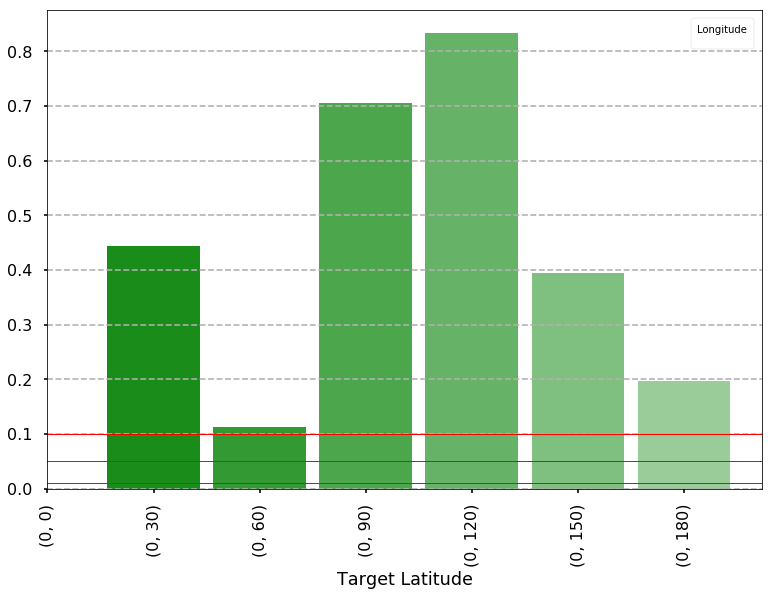

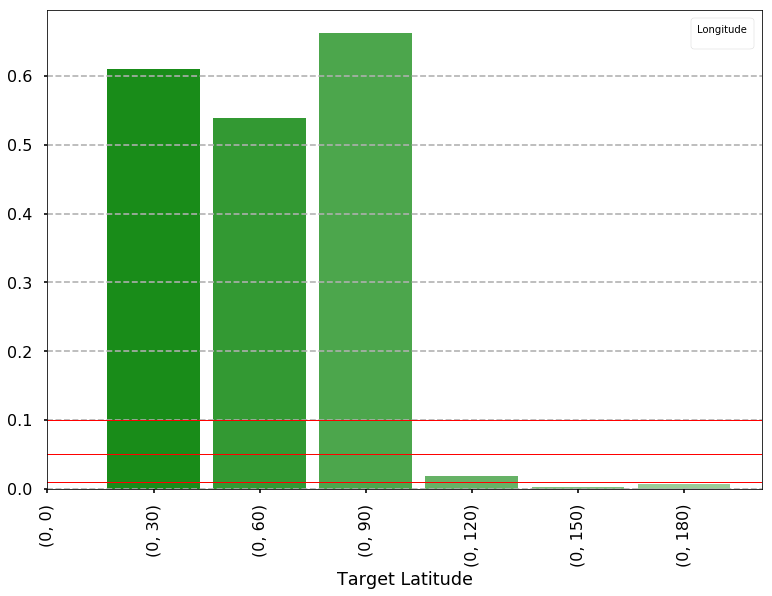

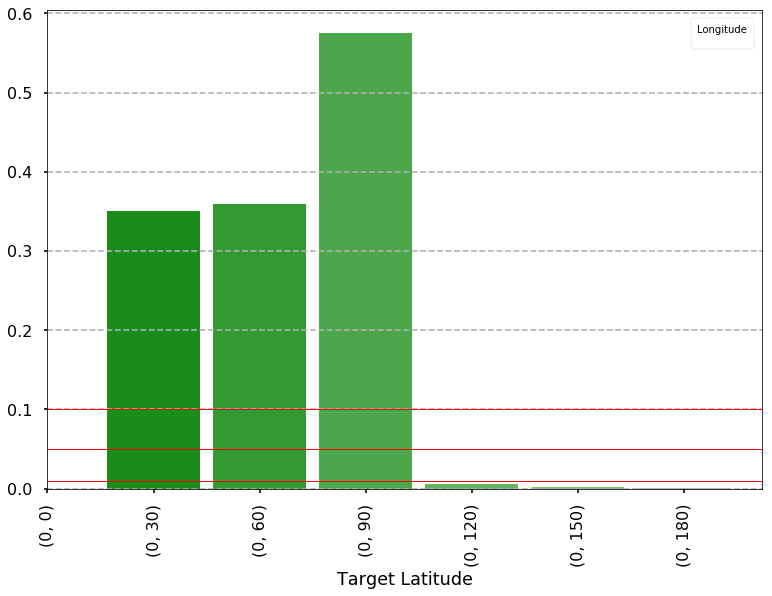

In [421]:
def cal_ttest(t1, t2):
    print(np.array(t1).shape)
    print(np.array(t2).shape)
    
    tvalue=[]
    pvalue=[]
    for lat in range(len(t1[0])):
        tv=[]
        pv=[]
        for lon in range(7):
            all_user_t1=[]
            all_user_t2=[]
            for user in range(len(t1)):
                all_user_t1.append(t1[user][lat][lon])
                all_user_t2.append(t2[user][lat][lon])

            t,p = ttest_rel(all_user_t1, all_user_t2)
            tv.append(t) # *7
            pv.append(p)
        tvalue.append(tv)
        pvalue.append(pv)# *3

    return tvalue, pvalue

if (False):
    speed_t, speed_p = cal_ttest(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7)
    plot_bar_single(speed_p)

    time_t, time_p = cal_ttest(test1.time_mean_10x3x7, test2.time_mean_10x3x7)
    plot_bar_single(time_p)
    
if (True):
    
    speed_t_35, speed_p_35 = cal_ttest(test3.speed_mean_10x3x7, test5.speed_mean_10x3x7)
    speed_t_34, speed_p_34 = cal_ttest(test3.speed_mean_10x3x7, test4.speed_mean_10x3x7)
    speed_t_45, speed_p_45 = cal_ttest(test4.speed_mean_10x3x7, test5.speed_mean_10x3x7)
    plot_bar_single(speed_p_34)
    plot_bar_single(speed_p_35)
    plot_bar_single(speed_p_45)
    print(np.array(test3.speed_mean_10x3x7))
    print(test4.speed_mean_10x3x7)
    print(test5.speed_mean_10x3x7)


3 - 4
Ttest_relResult(statistic=-1.2563905279149379, pvalue=0.26447818070629037)
4 - 5
Ttest_relResult(statistic=6.682574444739181, pvalue=0.001134098111934199)
3 - 5
Ttest_relResult(statistic=4.062850340104146, pvalue=0.009701886314540779)


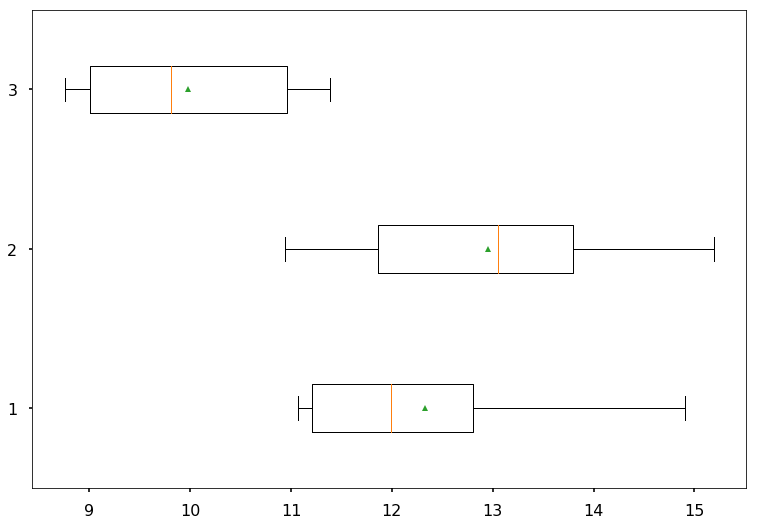

In [438]:
new_r_3 = np.array(test3.round_10x4).T # 4*10
new_r_4 = np.array(test4.round_10x4).T
new_r_5 = np.array(test5.round_10x4).T

new_r_3_mean = [np.mean(i) for i in test3.round_10x4] # 1*10
new_r_4_mean = [np.mean(i) for i in test4.round_10x4]
new_r_5_mean = [np.mean(i) for i in test5.round_10x4]


#print("ANOVA")

print("3 - 4")
print(ttest_rel(new_r_3_mean, new_r_4_mean))
print("4 - 5")
print(ttest_rel(new_r_4_mean, new_r_5_mean))
print("3 - 5")
print(ttest_rel(new_r_3_mean, new_r_5_mean))

fig, ax = plt.subplots()
ax.boxplot([new_r_3_mean, new_r_4_mean, new_r_5_mean],  0, 'rD',0, showmeans=True,)
plt.show()

In [422]:
X = [-30,0,30]
Y = [0,30,60,90,120,150,180]
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z)
print(type(Z))
print(Z[0][0].shape ==())

[[-0.98803162  0.         -0.98803162]
 [-0.99988891 -0.98803162 -0.99988891]
 [-0.89507243 -0.30481062 -0.89507243]
 [ 0.58148287  0.89399666  0.58148287]
 [-0.9211618   0.58061118 -0.9211618 ]
 [ 0.82344414 -0.71487643  0.82344414]
 [ 0.26721522 -0.80115264  0.26721522]]
<class 'numpy.ndarray'>
True


In [399]:
print(np.arange(-5, 5, 0.25))

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


In [400]:
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
print(x)
print(y)
print(top)
print(bottom)
listx = list(x)
listx.sort()
print(listx)
print(listx[1:-1])
print(np.median([5,1,2,5]))


[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[0 1 2 3 1 2 3 4 2 3 4 5 3 4 5 6 4 5 6 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3]
3.5


In [401]:
A = np.random.rand(5, 5)

print(np.delete(A,6))
print(A)

[0.83783764 0.11861562 0.79723474 0.94900427 0.14806288 0.90687198
 0.76840584 0.59849648 0.44214562 0.72303802 0.41661825 0.2268104
 0.45422734 0.84794375 0.93665595 0.95603618 0.39209432 0.70832467
 0.12951583 0.35379639 0.40427152 0.6485339  0.03307097 0.53800936]
[[0.83783764 0.11861562 0.79723474 0.94900427 0.14806288]
 [0.90687198 0.78837333 0.76840584 0.59849648 0.44214562]
 [0.72303802 0.41661825 0.2268104  0.45422734 0.84794375]
 [0.93665595 0.95603618 0.39209432 0.70832467 0.12951583]
 [0.35379639 0.40427152 0.6485339  0.03307097 0.53800936]]


In [402]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))
print(data)

[ 70.03673039  74.27508094  70.92800107  56.67455225  97.77853328
  70.6334846   24.79157587  15.78833509  69.76985214  71.99566667
  25.77444303  34.15467831  96.87611677  69.45070978  46.63832593
  70.28126954  51.1785874   92.874137    73.97692989  62.24390337
  65.15454689  39.68076115  54.32393949  79.98995282  72.15447266
  29.53639811  16.09458806  20.61255148  13.43253868  48.06050174
  34.25218134  36.29692901  97.29176387  11.09436116  38.82640891
  78.30658753  97.28972601  48.32096053  33.64211054  56.74190362
   4.79415097  38.8937029   90.63036451  16.10182093  74.36211347
  63.29741618  32.41800177  92.23765324  23.72264387  82.39455709
  50.          50.          50.          50.          50.
  50.          50.          50.          50.          50.
  50.          50.          50.          50.          50.
  50.          50.          50.          50.          50.
  50.          50.          50.          50.          50.
 175.06071403 111.37844527 184.53612452 192.393212

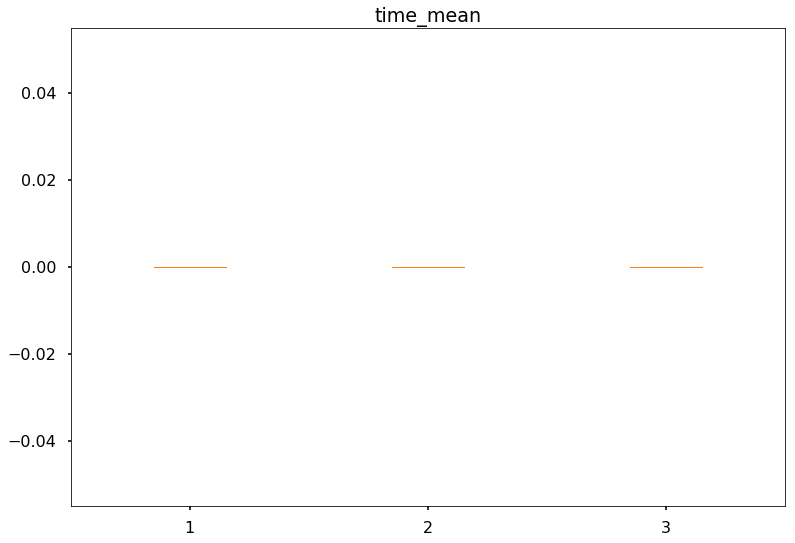

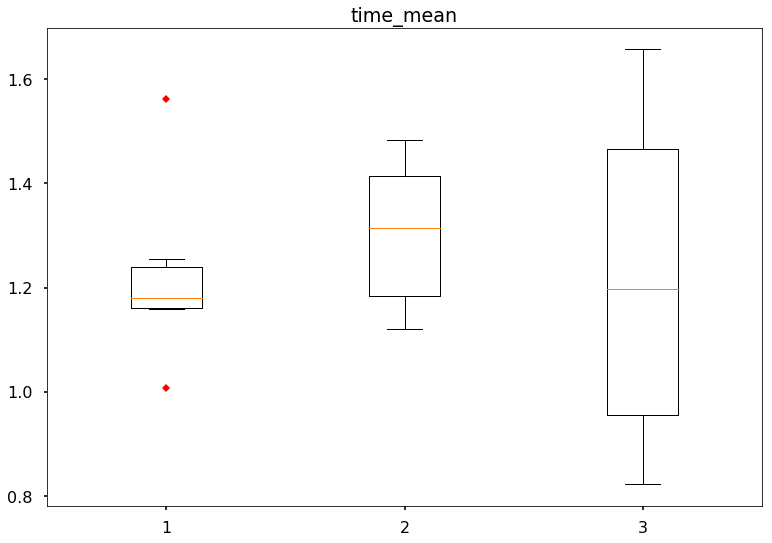

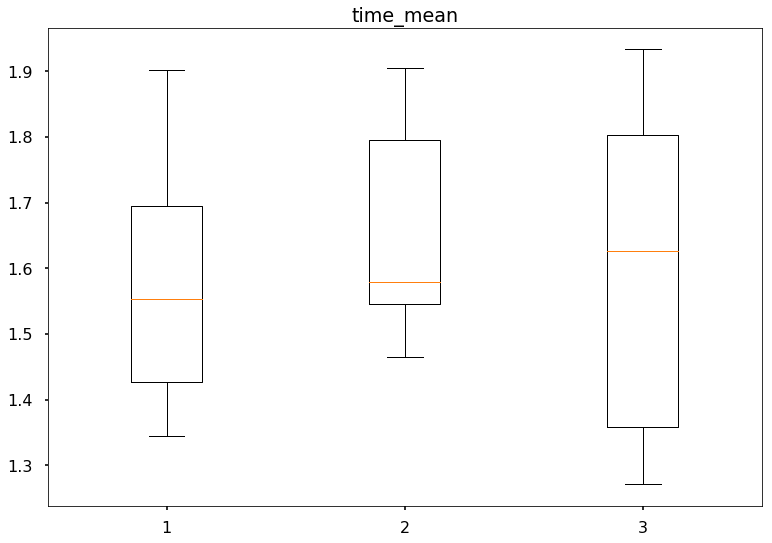

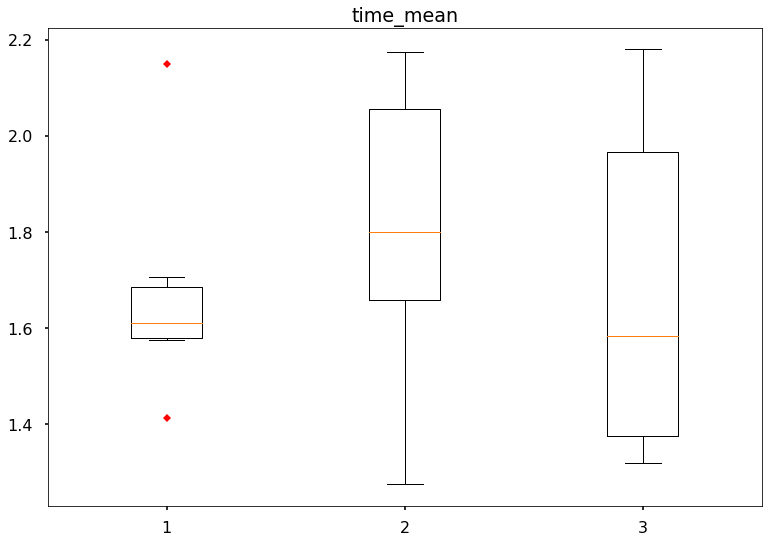

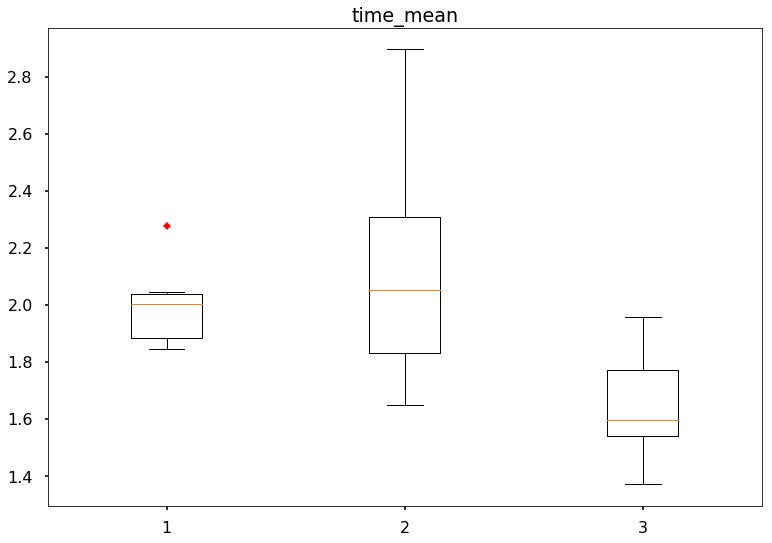

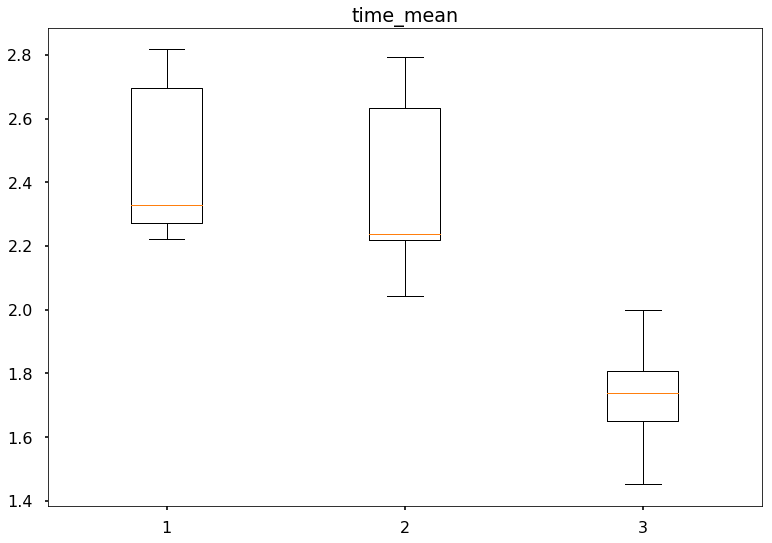

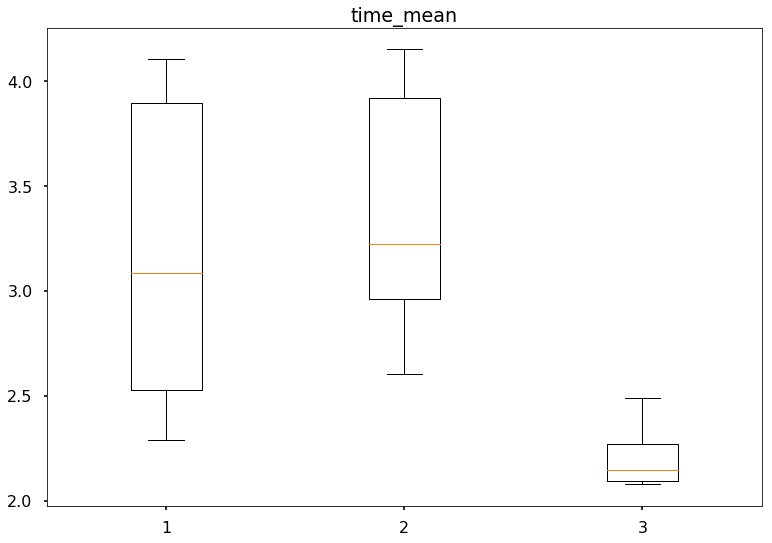

In [413]:
for i in range(len(Exp.deform(test3.time_mean_10x3x7)[0])):
    fig4, ax4 = plt.subplots()
    ax4.set_title('time_mean')
    allone = [Exp.deform(test3.time_mean_10x3x7)[0][i], 
              Exp.deform(test4.time_mean_10x3x7)[0][i], Exp.deform(test5.time_mean_10x3x7)[0][i]]
    ax4.boxplot(allone,0, 'rD')


In [430]:
#import csv


with open('people1.csv', 'a') as csvFile:
    writer = csv.writer(csvFile)
    for i in range(len(Exp.deform(test3.speed_mean_10x3x7)[0])):
        #for j in range(len(Exp.deform(test3.speed_mean_10x3x7)[0][0])):
        for j in range(len(Exp.deform(test3.speed_mean_10x3x7)[0][0])):
            row = [Exp.deform(test3.speed_mean_10x3x7)[0][i][j], 
               Exp.deform(test4.speed_mean_10x3x7)[0][i][j], Exp.deform(test5.speed_mean_10x3x7)[0][i][j], i ,j]
            writer.writerow(row)
    
csvFile.close()



for i in range(len(Exp.deform(test3.speed_mean_10x3x7)[0])):
    #print(Exp.deform(test3.speed_mean_10x3x7)[0][i], 
    #Exp.deform(test4.speed_mean_10x3x7)[0][i], Exp.deform(test5.speed_mean_10x3x7)[0][i])
    print(stats.f_oneway(Exp.deform(test3.speed_mean_10x3x7)[0][i], 
    Exp.deform(test4.speed_mean_10x3x7)[0][i], Exp.deform(test5.speed_mean_10x3x7)[0][i]))

F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=0.3762181024566299, pvalue=0.6927499003154127)
F_onewayResult(statistic=0.5270771736458199, pvalue=0.6008674630490782)
F_onewayResult(statistic=0.23824586235213419, pvalue=0.7909345448402787)
F_onewayResult(statistic=5.597932014833006, pvalue=0.015273514668171692)
F_onewayResult(statistic=20.63863578326552, pvalue=4.93385849149359e-05)
F_onewayResult(statistic=14.120591719495868, pvalue=0.00035600218026102693)


/anaconda3/envs/leoncv/lib/python3.7/site-packages/scipy/stats/stats.py:2961: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


In [431]:
print([i for i in range(4)])

[0, 1, 2, 3]
